In [1]:
import pandas as pd

import numpy as np
import scipy as sp
from scipy import signal
from scipy import ndimage
from scipy.ndimage.morphology import binary_closing
from scipy.optimize import curve_fit
from scipy.misc import imsave
import scipy.io as sio
import scipy.stats as st
from scipy.stats import norm

import cv2
from PIL import ImageFilter
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops, label, find_contours
from skimage.restoration import unwrap_phase
from skimage.feature import blob_log, canny
from skimage.exposure import equalize_hist

import random
import os
import fnmatch
import math
import re

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from timeit import default_timer as timer

In [3]:
def generate_ref_wave():
    return None

In [4]:
def noise(mu, epsilon):
    b = np.abs(mu) * np.cos(epsilon)
    f = (1-np.power(np.abs(mu),2))/(2*np.pi)
    g = np.power(1-np.power(b,2),(-3/2))
    h = (b * np.arcsin(b))+((np.pi*b)/2) + np.power(1-np.power(b,2),(1/2))
    
    return f*g*h

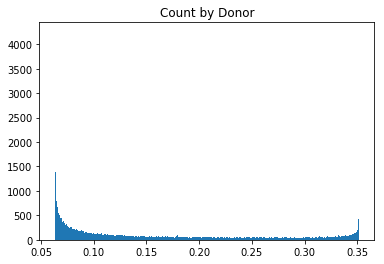

In [5]:
mu = 0.5

#uniform = np.random.uniform(-math.pi,math.pi,1000)
uniform = np.random.uniform(-100,100,100000)
noise_dist = [noise(mu,e) for e in uniform]

bins = np.linspace(np.min(noise_dist), np.max(noise_dist), 1000)

plt.title("Count by Donor")
plt.hist(noise_dist,bins)
plt.show()

In [6]:
%load_ext line_profiler

1000000


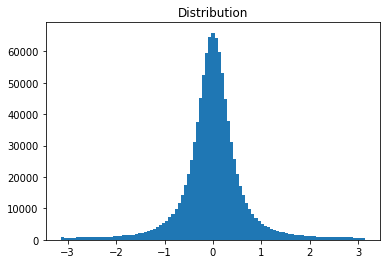

In [78]:
class my_pdf(st.rv_continuous):
    def __init__(self,momtype,a,b,name):
        super().__init__(momtype=momtype,a=a,b=b,name=name)
        
        self.mu = 0.9
        self.f = (1-np.power(self.mu,2))/(2*np.pi)
    def _pdf(self,epsilon):
        b = self.mu * np.cos(epsilon)
        inv_b = 1-np.power(b,2)
        g = 1/np.sqrt(np.power(inv_b,3))
        h = (b * np.arcsin(b))+((np.pi*b)/2) + np.sqrt(inv_b)
        
        return self.f*g*h
    
    def rvs(self,size):
        res = []
        pdf = self._pdf(0)
        
        while len(res) < size:
            uni = np.random.uniform(-math.pi,math.pi)
            sam = np.random.uniform(0,pdf)
            
            if sam < self._pdf(uni):
                res.append(uni)
            '''else:
                print("trial")
            print(self._pdf(uni))
            print(sam)'''
                
        '''uni = np.random.uniform(-math.pi,math.pi,size=size)
        sam = -self._pdf(0)*np.array([np.random.uniform(0,x,size=1) for x in uni])
        #sam = sam[0]
        res = [sam[ind] < self._pdf(x) for ind, x in enumerate(uni)]'''
        
        return res

my_cv = my_pdf(momtype=0,a=-math.pi, b=math.pi, name='my_pdf')

#uniform = np.random.uniform(-math.pi,math.pi,1000)
#uniform = np.random.uniform(-math.pi,math.pi,1000)
noise_dist = my_cv.rvs(size=1000000)

print(len(noise_dist))

bins = np.linspace(-math.pi, math.pi, 100)

plt.title("Distribution")
plt.hist(noise_dist,bins)
plt.show()

In [13]:
my_cv.var()

1.7852634251148973

In [77]:
%lprun -f my_cv.rvs my_cv.rvs(size=1000000)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  del sys.path[0]


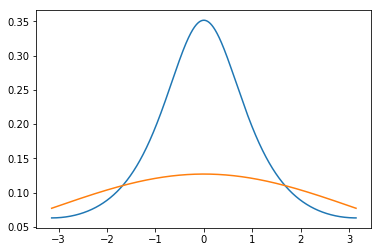

In [29]:
mu = 0.5

epsilon = np.linspace(-math.pi, math.pi, 5000)

b = np.abs(mu) * np.cos(epsilon)
f = (1-np.power(np.abs(mu),2))/(2*np.pi)
g = np.power(1-np.power(b,2),(-3/2))
h = (b * np.arcsin(b))+((np.pi*b)/2) + np.power(1-np.power(b,2),(1/2))

y = f*g*h

plt.plot(epsilon, y)
plt.plot(epsilon, mlab.normpdf(epsilon, 0, math.pi))

In [5]:
image_path = "I:\\Honours-Project\\data\\test data\\2017.4.13qc\\frames\\MATLAB_0003.avi_frame0.tif"
image_path = "I:\\Honours-Project\\data\\test data\\simulation\\test_hologram.mat"
#image_path = 'raw_phase.tif'
image_path = "I:\\Honours-Project\\data\\test data\\simulation\\panda_hologram.jpg"

In [6]:
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [7]:
mat_contents = sio.loadmat(image_path)
    
print(mat_contents['hologram'])
plt.imshow(mat_contents['hologram'])
gray = mat_contents['hologram']

TypeError: Expecting miMATRIX type here, got 84281096

In [8]:
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

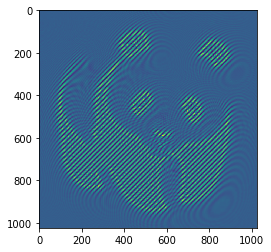

In [9]:
plt.imshow(gray)

[[ 8.64192560e+07      +0.j         -1.91757738e+06 -489792.99276991j
  -1.14121077e+06 +664398.3105572j  ... -7.92100375e+05+1151407.12857346j
  -1.14121077e+06 -664398.3105572j  -1.91757738e+06 +489792.99276991j]
 [-1.86783102e+06+2426403.72077194j -8.16326755e+04 -188967.26373126j
   1.20029789e+06 -487714.12073903j ... -1.62616001e+05 -309451.22668562j
   3.96418744e+05 -499335.110196j   -1.45103916e+05-1460083.9983115j ]
 [-1.35025658e+06 -972731.24803106j  3.78742502e+05 -261785.85101755j
   8.83334013e+05 +158687.27586153j ...  6.34898112e+05  +98975.48098012j
  -9.29055297e+04 +644698.85982295j  5.94474923e+05  -22122.17906271j]
 ...
 [-4.56998014e+05 +343625.58739232j  4.47004072e+05 -719601.76626505j
  -2.16034104e+04 -408016.92633123j ... -6.47725139e+04 -314983.74404096j
  -3.27070512e+05 +276196.30231806j  1.99863423e+05  +71496.84981697j]
 [-1.35025658e+06 +972731.24803106j  5.94474923e+05  +22122.17906271j
  -9.29055297e+04 -644698.85982295j ...  7.39987561e+04 -753110.4

TypeError: Image data cannot be converted to float

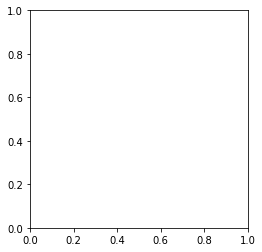

In [10]:
fourier = np.fft.fft2(gray)
print(fourier)
plt.imshow(fourier)

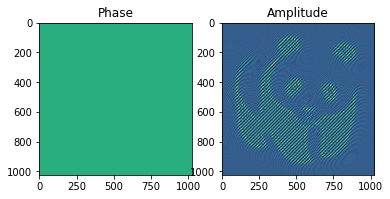

In [11]:
fourier = np.fft.fft2(gray)
#fourier = np.log(np.abs(fourier)+1);
#fourier = (fourier - np.min(np.min(fourier)))/(np.max(np.max(fourier))-np.min(np.min(fourier))); #Convert to range [0,1]

c = np.fft.ifft2(fourier)

ang = np.angle(c)
real = np.abs(c)

fig,ax = plt.subplots(1,2)

ax[0].set_title("Phase")
ax[0].imshow(ang)

ax[1].set_title("Amplitude")
ax[1].imshow(real)

#plt.imsave('amplitude.tif',(real+ang))
#plt.imsave('phase.tif',ang)

#sio.savemat('complex_inten.mat', dict(f=c))